# Агент работающий с SQL базами данных (ReAct)
В этом ноутбуке мы построим SQL агента, который будет:
1. Получать доступные таблицы в базе данных
2. Выбирать какие таблицы релевантны к запросу пользователя и получать их схему
3. Строить SQL-запрос к нужным таблицам (при построении SQL-запроса улучшаем его отдельным агентом с промптом)
4. Если на 2 шаге агент недополучил таблицы, агент не сможет сделать валидный 3-запрос и может вернуться на шаг 2
5. После успешного построения SQL запроса, включаем human-in-the-loop и просим обратную связь от человека насчет ответа от llm, здесь llm может на свое усмотрение вернутся обратно на 2 или 3 шаг
6. Если обратной связи нет, выводим ответ

Мы построим такой граф. Ниже описаны каждые его ноды
![](graph.png)

## Настраиваем окружение
Настроим переменные окружения для GigaChatz`

In [100]:
import os

os.environ["GIGACHAT_USER"] = "юзер"
os.environ["GIGACHAT_PASSWORD"] = "пароль"
os.environ["GIGACHAT_BASE_URL"] = "https://beta.saluteai.sberdevices.ru/v1"

# Настраиваем базу данных
Для этого ноутбука мы создадим базу данных SQLite. SQLite — это легковесная база данных, которую легко настроить и использовать. Мы будем загружать базу данных `chinook`, которая является примером базы данных, для цифрового магазина с музыкальными треками.
Более подробную информацию о этой базе данных можно найти [здесь](https://www.sqlitetutorial.net/sqlite-sample-database/).

In [101]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


Мы будем использовать удобную обёртку для работы с SQL-базами данных, доступную в пакете `gigachain_community`, чтобы взаимодействовать с базой данных. Обёртка предоставляет простой интерфейс для выполнения SQL-запросов и получения результатов.

In [ ]:
!pip install gigagraph gigachain-community

Проверяем работу базы данных

In [102]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [103]:
from langchain_community.chat_models import GigaChat
llm = GigaChat(
    verify_ssl_certs=False,
    timeout=6000,
    model="GigaChat-Pro",
    streaming=False,
)


## Определяем промпт
### Инструкции для ReAct агента
Это по сути тот же промпт для ReAct агента за исключением того, что мы в него добавим поддержку,
обратной связи от человека

In [104]:
REACT_FORMAT_INSTRUCTIONS = """
За один запрос ты можешь выполнить одну функцию
Question: *изначальный вопрос пользователя*

Используй следующий формат:
-----
[Начало цикла]
Thought: Введи здесь Мысль, что ты должен сделать
Action: [название функции, должно быть из списка [{tool_names}]]
Action Input: [параметры для функции]
Observation: Результат выполнения функции
[Конец цикла]
------
Цикл с вопросами может выполняться N раз Thought -> Action -> Action Input -> Observation
Если в результате выполнения функции ты не получил финальный ответ, выполни цикл еще раз
Когда ты знаешь окончательный ответ ты должен написать
-----
Thought: Теперь я знаю окончательный ответ
Final Answer: окончательный ответ на исходный вопрос
-----

Если у человека после твоего окончательного ответа возник вопрос (Human), возвращайся в начало цикла
"""

### Определяем остальные части
Тут инструкции для работы с SQL и план действий для агента

In [105]:
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate

SQL_PREFIX = """Ты специалист по SQL базам данных.
Получив входной вопрос ("Question"), создай синтаксически правильный запрос {dialect} для выполнения, затем посмотри на результаты запроса и верни ответ.
Если пользователь не указывает конкретное количество примеров, которые он хочет получить, ОБЯЗАТЕЛЬНО ограничивай свой запрос максимумом {top_k} результатов (LIMIT).
Ты можешь упорядочить результаты по релевантной колонке, чтобы вернуть наиболее интересные примеры из базы данных.
Никогда не запрашивай все колонки из конкретной таблицы, запрашивай только релевантные колонки, учитывая вопрос.
НЕ делай никаких DML-заявлений (INSERT, UPDATE, DELETE, DROP и т.д.) в базе данных.

Всегда свой ответ выводи с помощью Final Answer. Пример: Final Answer: твой ответ
Если вопрос, не связан с базой данных, верни свой ответ в Final Answer! Пример: Final Answer: твой ответ

У тебя есть инструменты для взаимодействия с базой данных.
Используй только приведенные ниже инструменты. Используй только информацию, возвращенную приведенными ниже инструментами, чтобы составить свой окончательный ответ.
У тебя есть набор следующих инструментов:
"""

template = "\n\n".join(
    [
        SQL_PREFIX,
        "{tools}",
        REACT_FORMAT_INSTRUCTIONS,
        """Question: "{input}"
Thought: Ты должен следовать следующим шагам:
1. посмотреть на таблицы в базе данных, чтобы увидеть, что я могу запросить.
2. Затем тебе следует запросить схему ВСЕХ РЕЛЕВАТНЫХ таблиц, которые будут участвовать в запросе
3. Написать запрос.
""",
    ]
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", template),
        (
            "user",
            "Начинаем!",
        ),
        MessagesPlaceholder("messages"),
    ]
)

 ## Определяем инструменты
Мы определим несколько инструментов, которые агент будет использовать для взаимодействия с базой данных.

1. `list_tables_tool`: Получить доступные таблицы из базы данных
2. `get_schema_tool`: Получить DDL для таблицы
3. `sql_db_query`: Выполнить запрос и получить результаты ИЛИ вернуть сообщение об ошибке, если запрос не выполнен

Эти инструменты мы возьмем из `SQLDatabaseToolkit`, которые доступны в пакете `gigachain_community`.

In [106]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

Убираем лишний инструмент, предназначенный для улучшения SQL запросов.
Мы будем улучшать SQL отдельной нодой после вызова инструмента выполения SQL. Это улучшает логику агента,
так как мы будем меньше забивать историю сообщений

In [107]:
tools = [tool for tool in tools if tool.name != "sql_db_query_checker"]

Проверяем тулы

In [108]:
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))

print(get_schema_tool.invoke("[\"Artist\"]"))

['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
CREATE TABLE "Artist" ("ArtistId" INTEGER NOT NULL, "Name" NVARCHAR(120), PRIMARY KEY ("ArtistId"))/*3 rows from Artist table:ArtistIdName1AC/DC2Accept3Aerosmith*/


Исходя из инструментов частично заполним промпт

In [109]:
from langchain.tools.render import render_text_description
prompt = prompt.partial(
    tools=render_text_description(list(tools)),
    tool_names=", ".join([t.name for t in tools]),
    dialect=toolkit.dialect,
    top_k=10,
)

In [110]:
llm_with_stop = llm.bind(stop=["Observation"])

## Определяем граф
### Определяем State

In [111]:
from typing import TypedDict, Annotated, Union, Optional
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.agents import AgentAction, AgentFinish, AgentStep


# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    input: str
    steps: list[Union[AgentAction, AgentFinish, AgentStep]]
    human: Optional[str]

### Определяем ноды графа
#### Нода первого шага
Здесь мы получаем имена таблиц в базе данных и из них делаем few-shot, чтобы гигачат начал лучше работать в шаблоне ReAct.

In [112]:
from langchain.agents.output_parsers import ReActSingleInputOutputParser
from langchain_core.messages import AIMessage

parser = ReActSingleInputOutputParser()


def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    message = AIMessage(
        content="Action: sql_db_list_tables\n" + "Action Input: {}",
    )
    return {"messages": [message], "steps": [parser.invoke(message)]}

#### Нода агента
Здесь мы вызываем llm
!!! ОСТОРОЖНО !!!: здесь внедрена логика повторного шага, если llm вернула не валидный ответ. Её в идеале нужно перейти с выходом из графа
если llm не может вернуть валидный ответ спустя n-попыток

In [113]:
from langchain_core.messages import HumanMessage
from langchain_core.exceptions import OutputParserException

tool_map = {tool.name: tool for tool in tools}
agent = prompt | llm_with_stop

def call_agent(state: State):
    step = None
    parsing_messages = []
    count = 0
    while step is None:
        message = agent.invoke(
            {**state, **{"messages": (state["messages"] + parsing_messages)}}
        )
        parsing_messages = []
        parsing_messages.append(message)
        count += 1
        try:
            step = parser.invoke(message)
        except OutputParserException as e:
            if count >= 5:
                raise Exception("Превышен retry")
            parsing_messages.append(HumanMessage(content=e.observation))
            print("restep!")
            print(message.content)
    return {
        "messages": [message],
        "steps": state["steps"] + [step],
        "human": None,
    }

#### Нода вызова инструментов
Здесь мы вызываем нужные инструменты

In [114]:
def call_tools(state: State):
    last_step = state["steps"][-1]
    tool = tool_map[last_step.tool]
    result = tool.invoke(last_step.tool_input)
    return {
        "messages": HumanMessage(content=f"Observation: {result}\nЧто дальше?"),
        "steps": state["steps"] + [AgentStep(action=last_step, observation=result)],
    }

#### Нода улучшения SQL-запроса

In [115]:
import re
import json

query_check_system = """Ты являешься экспертом по SQL, который внимателен к деталям.
Дважды проверь запрос SQLite на наличие распространённых ошибок, включая:
- Использование NOT IN с NULL-значениями
- Использование UNION, когда следовало использовать UNION ALL
- Использование BETWEEN для исключительных диапазонов
- Несоответствие типов данных в предикатах
- Правильное экранирование идентификаторов
- Использование правильного количества аргументов для функций
- Приведение к правильному типу данных
- Использование правильных столбцов для соединений
- YEAR функции в SQLITE нет, используй strftime
- ОБЯЗАТЕЛЬНО Используй в названии колонок символ `. Пример: SELECT `название колонки`
- ОБЯЗАТЕЛЬНО делай Alias с помощью AS. Пример: from `table` as t
- ОБЯЗАТЕЛЬНО ограничивай запрос с помощью LIMIT до количества {top_k} штук. Пример: LIMIT {top_k}

Если обнаружены какие-либо из вышеперечисленных ошибок, перепиши запрос. Если ошибок нет, просто воспроизведи оригинальный запрос.

После этой проверки ты вызовешь соответствующий инструмент для выполнения запроса.

SQL-запрос пользователя: {sql}

Верни SQL запрос в формате JSON
Пример:
{{"sql": "твой sql запрос"}}"""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
).partial(top_k=10)
query_check = query_check_prompt | llm.bind(model="GigaChat-Pro")


def model_check_query(state: State):
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    response = query_check.invoke({"sql": state["steps"][-1].tool_input})
    sql = json.loads(response.content)["sql"]
    state["steps"][-1].tool_input = sql
    state["messages"][-1].content = re.sub(
        r"Action Input:.*",
        f"Action Input: {sql}",
        state["messages"][-1].content,
        1,
        re.DOTALL,
    )
    return state

#### Нода обратной связи от человека

In [121]:
def human_feedback(state: State):
    human = input("Вопросы (если нет пиши no)? ")
    if human == "no" or not human:
        human = None
    return {
        "human": human,
        "messages": HumanMessage(content=f"Human: \"{human}\""),
    }

### Настраиваем ноды и их связки между собой

In [122]:
from langgraph.graph import StateGraph
from typing import Literal

from langgraph.constants import START

workflow = StateGraph(State)

workflow.add_node("first_tool_call", first_tool_call)
workflow.add_node("call_tools", call_tools)
workflow.add_node("call_agent", call_agent)
workflow.add_node("model_check_query", model_check_query)
workflow.add_node("human_feedback", human_feedback)


def should_continue(
    state: State,
) -> Literal["human_feedback", "model_check_query", "call_tools"]:
    last_step = state["steps"][-1]
    if isinstance(last_step, AgentFinish):
        return "human_feedback"
    elif last_step.tool == "sql_db_query":
        return "model_check_query"
    else:
        return "call_tools"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "call_tools")
workflow.add_edge("call_tools", "call_agent")
workflow.add_edge("model_check_query", "call_tools")
workflow.add_conditional_edges(
    "call_agent",
    should_continue,
)


def human_continue(state) -> Literal["call_agent", "__end__"]:
    return "__end__" if state["human"] is None else "call_agent"


workflow.add_conditional_edges(
    "human_feedback",
    human_continue,
)

# Compile the workflow into a runnable
app = workflow.compile()

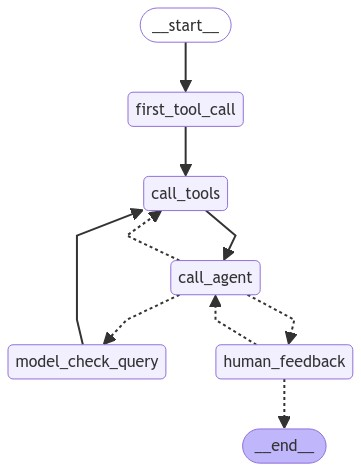

In [38]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# Примеры вызова графа

In [119]:
for event in app.stream(
    {
        "messages": [],
        "input": "Получи количество треков",
        "steps": [],
        "human": None,
    },
    {"recursion_limit": 100},
    stream_mode="values",
):
    if event["messages"]:
        print(event["messages"][-1].content)

Action: sql_db_list_tables
Action Input: {}
Observation: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Что дальше?
Thought: Я вижу, что в базе данных есть таблица "Track". Я должен запросить схему этой таблицы, чтобы узнать, какие столбцы в ней содержатся.

Action: sql_db_schema
Action Input: ["Track"]
Observation: CREATE TABLE "Track" ("TrackId" INTEGER NOT NULL, "Name" NVARCHAR(200) NOT NULL, "AlbumId" INTEGER, "MediaTypeId" INTEGER NOT NULL, "GenreId" INTEGER, "Composer" NVARCHAR(220), "Milliseconds" INTEGER NOT NULL, "Bytes" INTEGER, "UnitPrice" NUMERIC(10, 2) NOT NULL, PRIMARY KEY ("TrackId"), FOREIGN KEY("MediaTypeId") REFERENCES "MediaType" ("MediaTypeId"), FOREIGN KEY("GenreId") REFERENCES "Genre" ("GenreId"), FOREIGN KEY("AlbumId") REFERENCES "Album" ("AlbumId"))/*3 rows from Track table:TrackIdNameAlbumIdMediaTypeIdGenreIdComposerMillisecondsBytesUnitPrice1For Those About To Rock (We Salute Yo

In [123]:
for event in app.stream(
    {
        "messages": [],
        "input": "Выведи названия альбомов led zeppelin",
        "steps": [],
        "human": None,
    },
    {"recursion_limit": 100},
    stream_mode="values",
):
    if event["messages"]:
        print(event["messages"][-1].content)

Action: sql_db_list_tables
Action Input: {}
Observation: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Что дальше?
Thought: Из списка таблиц я вижу, что мне нужно использовать таблицу "Album".

Action: sql_db_schema
Action Input: ["Album"]
Observation: CREATE TABLE "Album" ("AlbumId" INTEGER NOT NULL, "Title" NVARCHAR(160) NOT NULL, "ArtistId" INTEGER NOT NULL, PRIMARY KEY ("AlbumId"), FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId"))/*3 rows from Album table:AlbumIdTitleArtistId1For Those About To Rock We Salute You12Balls to the Wall23Restless and Wild2*/
Что дальше?
Thought: Я получил схему таблицы "Album" и несколько образцов строк. Теперь я могу написать запрос, чтобы вывести названия альбомов Led Zeppelin.

Action: sql_db_query
Action Input: "SELECT Title FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'Led Zeppelin');"
Thought: Я получил схему таблицы "Album" и неско

In [124]:
for event in app.stream(
    {
        "messages": [],
        "input": "Выведи следующую информацию о треках из плейлиста Grunge: Название исполнителя — название трека",
        "steps": [],
        "human": None,
    },
    {"recursion_limit": 100},
    stream_mode="values",
):
    if event["messages"]:
        print(event["messages"][-1].content)

Action: sql_db_list_tables
Action Input: {}
Observation: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Что дальше?
Thought: Из списка таблиц видно, что мне нужно использовать таблицы Playlist, PlaylistTrack и Track.
Action: sql_db_schema
Action Input: ["Playlist", "PlaylistTrack", "Track"]
Observation: CREATE TABLE "Playlist" ("PlaylistId" INTEGER NOT NULL, "Name" NVARCHAR(120), PRIMARY KEY ("PlaylistId"))/*3 rows from Playlist table:PlaylistIdName1Music2Movies3TV Shows*/
CREATE TABLE "PlaylistTrack" ("PlaylistId" INTEGER NOT NULL, "TrackId" INTEGER NOT NULL, PRIMARY KEY ("PlaylistId", "TrackId"), FOREIGN KEY("TrackId") REFERENCES "Track" ("TrackId"), FOREIGN KEY("PlaylistId") REFERENCES "Playlist" ("PlaylistId"))/*3 rows from PlaylistTrack table:PlaylistIdTrackId134021338913390*/
CREATE TABLE "Track" ("TrackId" INTEGER NOT NULL, "Name" NVARCHAR(200) NOT NULL, "AlbumId" INTEGER, "MediaTypeId" INTEGER NO